In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_1_SingleSequence import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
import lin_approx
mpl.rc('text', usetex = True)
mpl.rc('font', **{'family': 'serif', 'size': 20})
mpl.rcParams.update({'font.size': 20})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scan for p_ff and p_rc
As in Chenkov 2017

In [7]:
fname_res = 'data/1_r_oneseq.pckl'

t = params['t']

In [8]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_res)

else:
    
    r = np.zeros([
        len(params['range_p_rc']),
        len(params['range_p_ff']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, p_rc_i in enumerate(tqdm(params['range_p_rc'])):
        for j, p_ff_i in enumerate(params['range_p_ff']):
            sim = sim_wc.Simulator(params)
            sim.p['p_rc'] = p_rc_i
            sim.p['p_ff'] = p_ff_i
            sim.set_interaction_matrix()

            
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
            
    tools_wc.save_pckl(r, fname_res)

In [9]:
r_sel = params['r_sel']

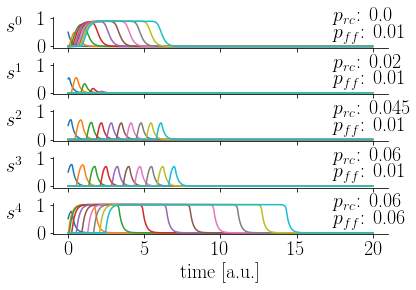

In [10]:
fig, ax = plt.subplots(
    len(r_sel), 1, sharex=True, sharey=True,
    squeeze=False, figsize=(6,4),
    gridspec_kw={
        'hspace': 0.5})
   
for i, r_i in enumerate(r_sel):
    p_rc_i =r_i['p_rc']
    p_ff_i =r_i['p_ff'] 
    
    pos_p_rc_i = np.where(params['range_p_rc'] == p_rc_i)[0][0]
    pos_p_ff_i = np.where(params['range_p_ff'] == p_ff_i)[0][0]
    
    r_ii = r[pos_p_rc_i, pos_p_ff_i]
    seq_i = params['seqs'][0]
    
    #plot rates
    ax[i, 0].plot(t,  r_ii[:, seq_i[::3]*2])
    
    # annotate
    ax[i, 0].spines['right'].set_visible(False)
    ax[i, 0].spines['top'].set_visible(False)
    
    ax[i, 0].text(-4, .5, r'$s^{'+str(i)+'}$')
    ax[i, 0].text(17.3, 0.9, r'$p_{rc}$: '+str(p_rc_i))
    ax[i, 0].text(17.3, 0.3, r'$p_{ff}$: '+str(p_ff_i))

#    ax[i, 0].set_ylim(0.7, 1.)
#ax[2, 0].set_ylabel(r'$r^E$', rotation=0)

ax[-1, 0].set_xlabel('time [a.u.]')
plt.savefig('figures/1_SingleSequence_examples.svg')

### Test for successful reactivation

In [11]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff'])], dtype=bool)
cond = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff']),
    4], dtype=bool)

mean_t_act = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff'])])
mean_act = np.zeros([
    len(params['range_p_rc']),
    len(params['range_p_ff'])])

dt = np.mean(np.unique(np.diff(params['t'])))

seq = params['seqs'][0]
for i, p_rc_i in enumerate(tqdm(params['range_p_rc'])):
    for j, p_ff_i in enumerate(params['range_p_ff']):
        rE_ij = rE[i, j, :, :]        
        (crit[i, j],
         cond[i, j, 0],
         cond[i, j, 1],
         cond[i, j, 2],
         cond[i, j, 3]) = tools_wc.peak_criterium(
             rE_ij, params['r_min'], seq, params['tol'], return_conds=True)
        mean_t_act[i, j] = tools_wc.mean_activation_time(rE_ij, params['r_min'], seq, dt)
        
        rE_ij_without0 = np.copy(rE_ij)
        rE_ij_without0[rE_ij_without0<params['r_min']] = np.nan
        mean_act[i, j] = np.nanmean(rE_ij_without0)

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: No contour levels were found within the data range.


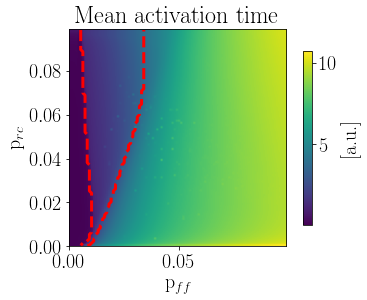

In [57]:
fig, ax = plt.subplots(1, figsize=(6,4))

crt_map = cm.get_cmap()
crt_map.set_bad(color='grey')

#ax.set_aspect('equal')
#mean_t_act[~crit] = np.nan
im = ax.imshow(
    mean_t_act,
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]])
im2 = ax.contour(
    crit,
    levels=[False, True],
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    colors='red',
    linewidths=3.,
    linestyles='dashed')


#xticks = ax.get_xticks()
#ax.set_yticks(xticks)
cbar = plt.colorbar(im, shrink=0.8)
cbar.ax.set_ylabel('[a.u.]', rotation=90)
plt.xlabel(r'p$_{ff}$')
plt.ylabel(r'p$_{rc}$')

plt.title('Mean activation time')
plt.savefig('figures/1_SingleSequence_MeanActivationTime_prc_pff_scan.svg')

./lin_approx.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  


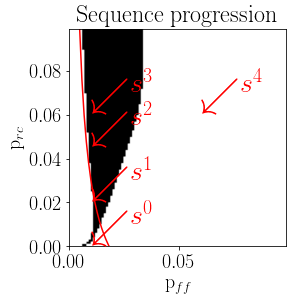

In [52]:
fig, ax = plt.subplots(1, figsize=(5,4))

crt_map = cm.get_cmap()
cmap = mpl.cm.get_cmap('Greys')

#ax.set_aspect('equal')
#mean_t_act[~crit] = np.nan
im = ax.imshow(
    crit,
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    vmin=0,
    vmax=1,
cmap=cmap)
ax.set_xlabel(r'p$_{ff}$')
#xticks = ax.get_xticks()
#ax.set_yticks(xticks)
plt.xlabel(r'p$_{ff}$')
plt.ylabel(r'p$_{rc}$')

for i, r_i in enumerate(r_sel):
    p_rc_i =r_i['p_rc']
    p_ff_i =r_i['p_ff'] 
    plt.text(p_ff_i, p_rc_i,
        r'$\swarrow^{s^'+str(i)+'}$',
        #r'$*^{s^'+str(i)+'}$',
        #r'$\downarrow^{s^'+str(i)+'}$',
             color='r', fontsize=40,
        horizontalalignment='left',
        verticalalignment='bottom')
    
# insert linear approximation
try:
    fun_lin = tools_wc.import_if_exists('lin_approx', 'minimal_p_rc')
    p_rc_lin = []
    for p_ff_i in params['range_p_ff']:
        p_rc_i = fun_lin(
            c=params['c'],
            p__11_ff=p_ff_i,
            g__11_ff=params['gE']*params['pot_ff'][0],
            M__1=params['nE'][0],
            g_rc=params['gE'],
        )
        p_rc_lin.append(p_rc_i)

    ax.plot(params['range_p_ff'], p_rc_lin, c='r')
    ax.set_ylim(params['range_p_rc'][0], params['range_p_rc'][-1])
    ax.set_xlim(params['range_p_ff'][0], params['range_p_ff'][-1])
except:
    print('Linear approximation functio not found')


plt.title('Sequence progression')
plt.savefig('figures/1_SingleSequence_SuccessfulReactivation_prc_pff_scan.svg')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: No contour levels were found within the data range.


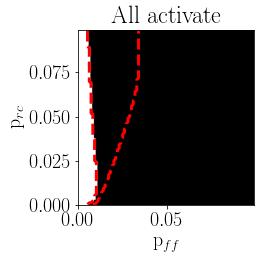

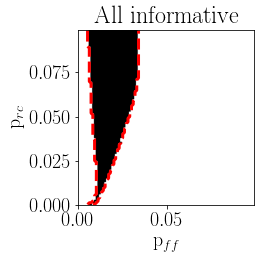

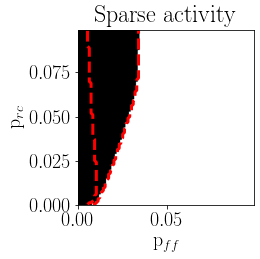

In [56]:
ls_title = ['All activate', 'All informative', 'Sparse activity']

cmap = mpl.cm.get_cmap('Greys')

for i in range(3):
    fig, ax = plt.subplots(1, figsize=(4,4))
    
    ax.set_ylabel(r'p$_{rc}$')

    im = ax.imshow(
        cond[:, :, i],
        origin='lower',
        extent=[
            params['range_p_rc'][0],
            params['range_p_rc'][-1],
            params['range_p_ff'][0],
            params['range_p_ff'][-1]],
        vmin=0,
        vmax=1,
    cmap=cmap)
    ax.set_xlabel(r'p$_{ff}$')
    ax.set_title(ls_title[i])
    
    ax.contour(
    crit,
    levels=[False, True],
    origin='lower',
    extent=[
        params['range_p_rc'][0],
        params['range_p_rc'][-1],
        params['range_p_ff'][0],
        params['range_p_ff'][-1]],
    colors='red',
    linewidths=3.,
    linestyles='dashed')
    fig.tight_layout()
    plt.savefig('figures/1_SingleSequence_Cond_'+ls_title[i].replace(' ', '_')+'_prc_pff_scan.svg')


